In [5]:
!pip install pandas numpy matplotlib seaborn prophet statsmodels scikit-learn

In [9]:
DATA_PATH = "air_quality_data.csv"  # <-- put your CSV here or change to the correct filename
CITIES = ["Delhi", "Mumbai", "Kolkata", "Bengaluru"]
TARGET = "PM2.5"   # pollutant to forecast (column name must match the dataset)
RESAMPLE_RULE = "D"  # daily
SAVE_DIR = "/mnt/data/aqi_outputs"


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

os.makedirs(SAVE_DIR, exist_ok=True)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
# Load dataset
print("Loading", DATA_PATH)
try:
    df = pd.read_csv(DATA_PATH, parse_dates=True)
except Exception as e:
    raise SystemExit(f"Error loading {DATA_PATH}: {e}")

# Try to auto-detect timestamp and city columns
print("Columns:", df.columns.tolist())

# Common column names mapping (update if your CSV has different names)
possible_time_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
possible_city_cols = [c for c in df.columns if 'city' in c.lower() or 'station' in c.lower() or 'location' in c.lower()]

if not possible_time_cols:
    raise SystemExit("No time-like column found. Please ensure your CSV has a timestamp column (e.g., 'Date', 'timestamp').")
time_col = possible_time_cols[0]
city_col = possible_city_cols[0] if possible_city_cols else None

print("Using timestamp column:", time_col, "and city column:", city_col)

df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col])
if city_col is None:
    # if no city column, create a single-city dataset
    df['city'] = 'Unknown'
    city_col = 'city'
else:
    df[city_col] = df[city_col].astype(str)

# Keep only needed columns
cols = [time_col, city_col]
if TARGET in df.columns:
    cols.append(TARGET)
else:
    raise SystemExit(f"Target column '{TARGET}' not found in dataset. Available pollutant columns: {[c for c in df.columns if c not in cols]}")

df = df[cols].rename(columns={time_col: 'timestamp', city_col: 'city', TARGET: TARGET})
print("Data loaded. Sample:")
display(df.head())


Loading city_day.csv
Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
Using timestamp column: Date and city column: City
Data loaded. Sample:


,timestamp,city,PM2.5
0,2015-01-01,Ahmedabad,NaN
1,2015-01-02,Ahmedabad,NaN
2,2015-01-03,Ahmedabad,NaN
3,2015-01-04,Ahmedabad,NaN
4,2015-01-05,Ahmedabad,NaN


In [13]:
# Preprocess: resample to daily mean per city and handle missing values
# df = df.set_index('timestamp') # Removed this line
daily = df.groupby('city').resample(RESAMPLE_RULE).mean().reset_index()

# Basic missing handling: forward fill within each city then backward fill, then drop remaining NaNs
daily[TARGET] = daily.groupby('city')[TARGET].transform(lambda x: x.ffill().bfill())

# If still NaNs exist, fill with global median for that pollutant
if daily[TARGET].isna().sum() > 0:
    median_val = daily[TARGET].median()
    daily[TARGET] = daily[TARGET].fillna(median_val)

print("After resampling and filling, entries:", len(daily))
display(daily.groupby('city')[TARGET].agg(['count','min','max','mean']).reset_index())

After resampling and filling, entries: 29531


,city,count,min,max,mean
0,Ahmedabad,2009,3.04,381.69,92.980224
1,Aizawl,113,0.16,54.90,16.850531
2,Amaravati,951,4.65,139.38,36.280631
3,Amritsar,1221,2.85,868.66,53.366896
4,Bengaluru,2009,1.72,313.59,35.149388
5,Bhopal,289,3.40,136.42,48.989239
6,Brajrajnagar,938,2.54,308.79,62.879350
7,Chandigarh,304,6.86,154.85,40.714704
8,Chennai,2009,6.55,293.43,55.327556
9,Coimbatore,386,2.13,63.10,29.146969


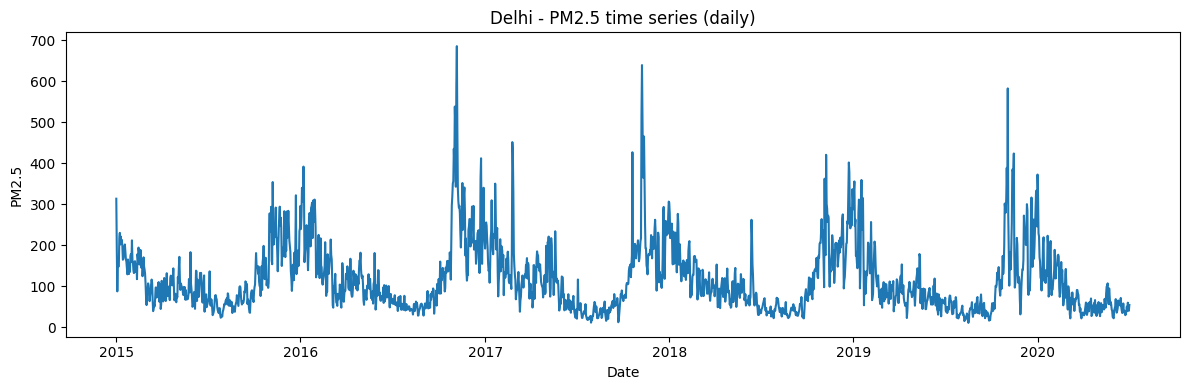

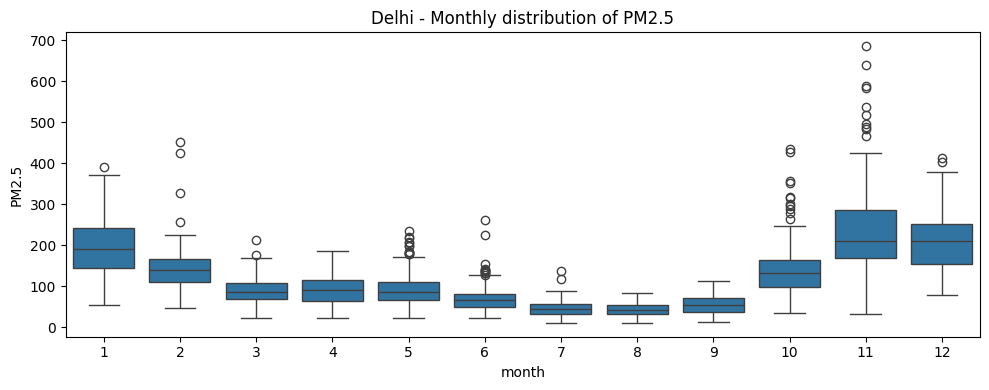

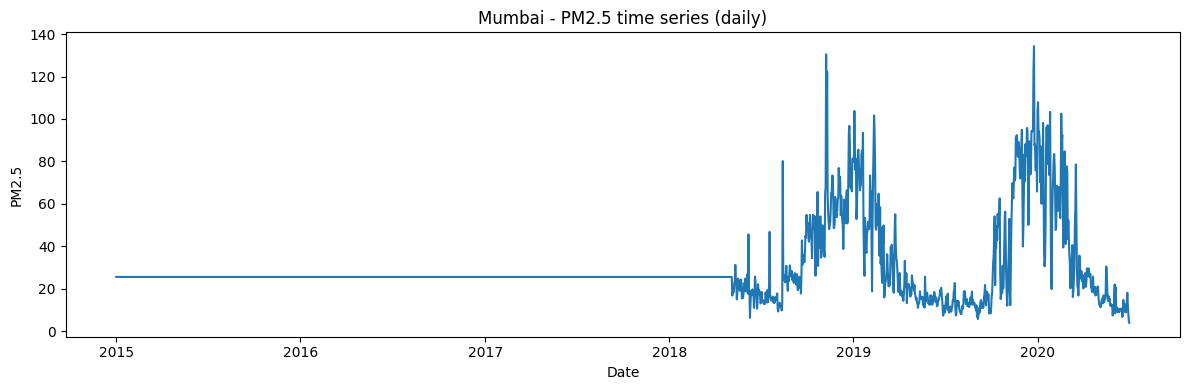

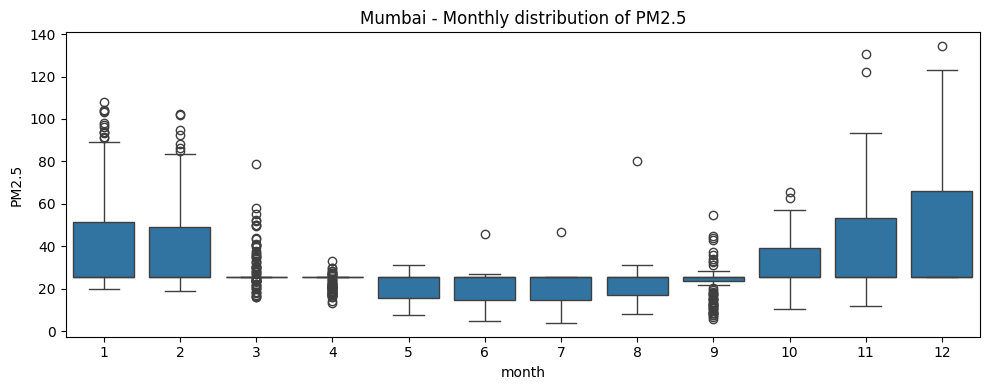

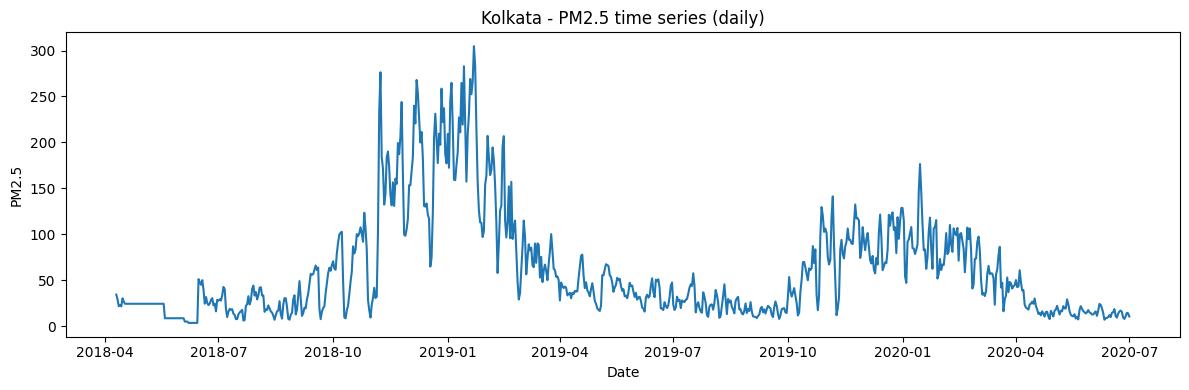

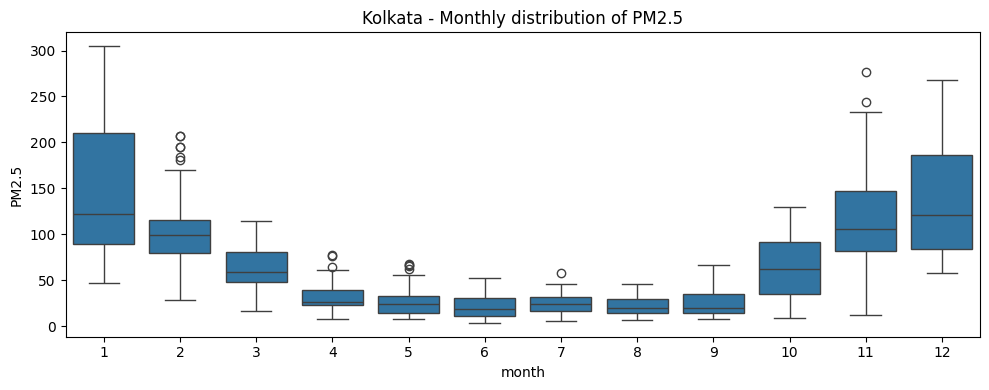

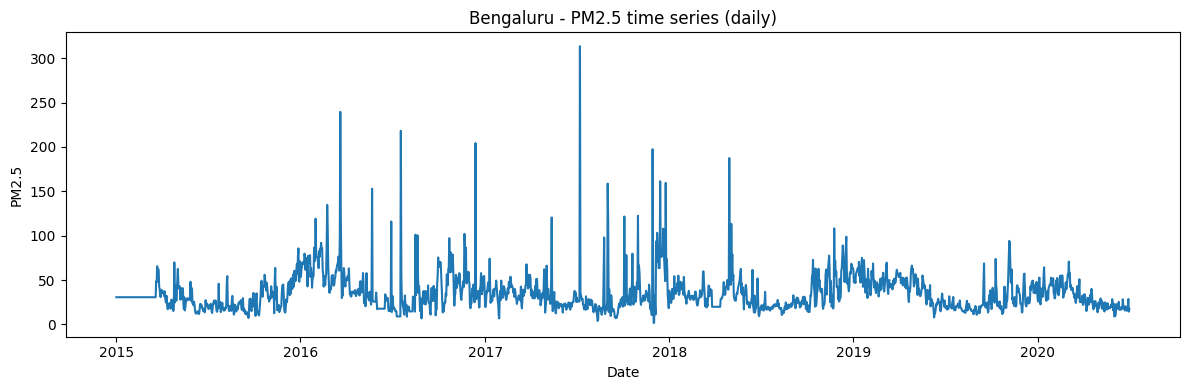

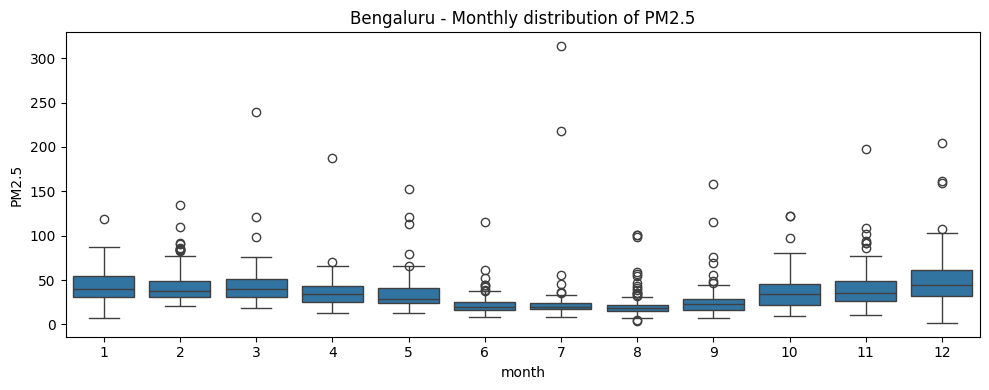

In [14]:

# Quick EDA: time series plot and seasonal boxplot for each city
for city in CITIES:
    city_df = daily[daily['city'].str.contains(city, case=False, na=False)]
    if city_df.empty:
        print(f"No data found for city pattern: {city} (skipping).")
        continue
    city_df = city_df.set_index('timestamp').sort_index()
    plt.figure(figsize=(12,4))
    plt.plot(city_df[TARGET])
    plt.title(f"{city} - {TARGET} time series (daily)")
    plt.xlabel("Date"); plt.ylabel(TARGET)
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/{city}_timeseries.png")
    plt.show()

    # Monthly boxplot
    city_df['month'] = city_df.index.month
    plt.figure(figsize=(10,4))
    sns.boxplot(x='month', y=TARGET, data=city_df.reset_index())
    plt.title(f"{city} - Monthly distribution of {TARGET}")
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/{city}_monthly_box.png")
    plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/x5drqum1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/jtyvu3b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69595', 'data', 'file=/tmp/tmpkx5hqvnw/x5drqum1.json', 'init=/tmp/tmpkx5hqvnw/jtyvu3b8.json', 'output', 'file=/tmp/tmpkx5hqvnw/prophet_model35cqmzmz/prophet_model-20250920183944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Delhi: Prophet MAE=34.67, RMSE=49.50 (test length 402)


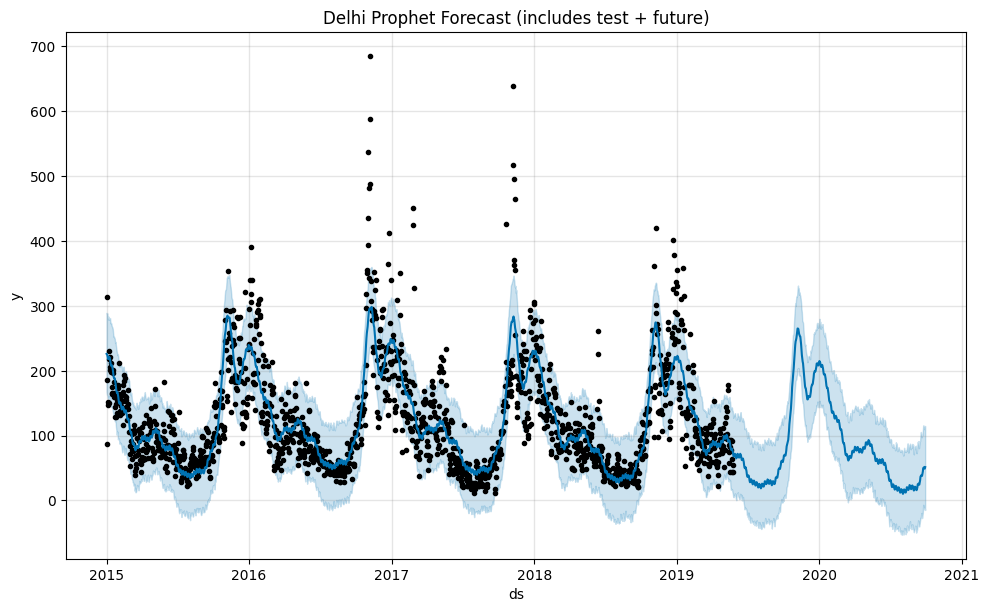

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/z11fnugj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/s1oqua5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15708', 'data', 'file=/tmp/tmpkx5hqvnw/z11fnugj.json', 'init=/tmp/tmpkx5hqvnw/s1oqua5r.json', 'output', 'file=/tmp/tmpkx5hqvnw/prophet_modelwvyu0_ur/prophet_model-20250920183945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mumbai: Prophet MAE=27.85, RMSE=30.31 (test length 402)


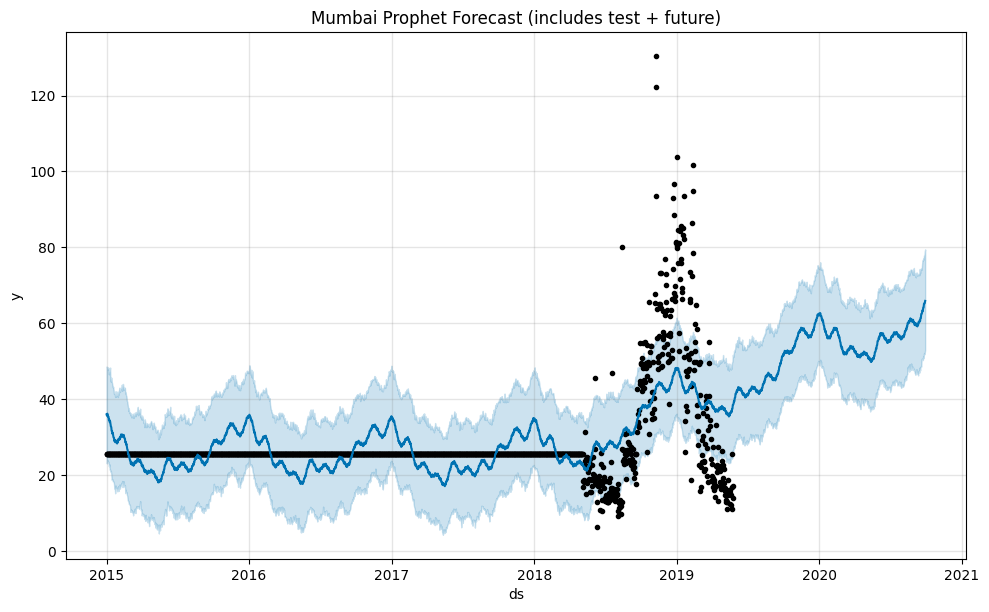

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/wrvojfl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/tv8jdffd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15869', 'data', 'file=/tmp/tmpkx5hqvnw/wrvojfl6.json', 'init=/tmp/tmpkx5hqvnw/tv8jdffd.json', 'output', 'file=/tmp/tmpkx5hqvnw/prophet_modelrlo8fx_9/prophet_model-20250920183946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Kolkata: Prophet MAE=114.29, RMSE=121.32 (test length 163)


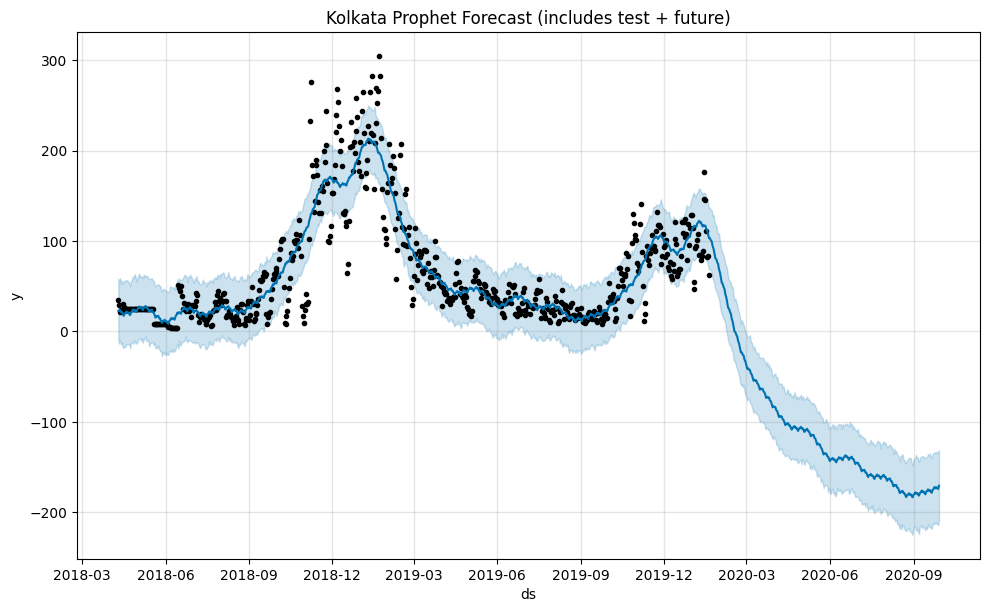

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/0o5feoy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx5hqvnw/kjk03hlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62654', 'data', 'file=/tmp/tmpkx5hqvnw/0o5feoy5.json', 'init=/tmp/tmpkx5hqvnw/kjk03hlb.json', 'output', 'file=/tmp/tmpkx5hqvnw/prophet_model6g_fgvqy/prophet_model-20250920183947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Bengaluru: Prophet MAE=18.70, RMSE=21.41 (test length 402)


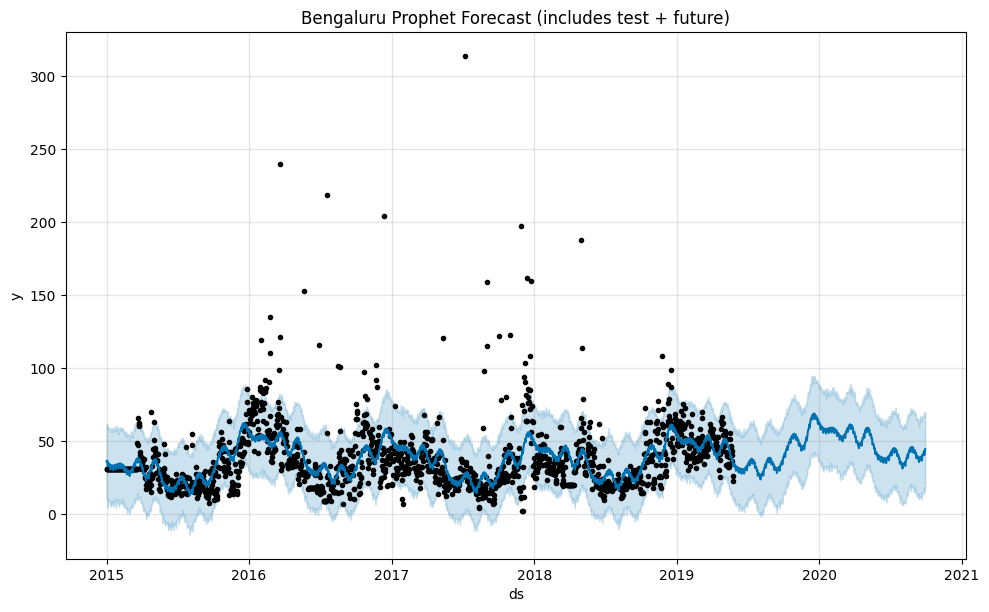

In [15]:

# Prophet forecasting for each city (PM2.5). We'll use last 20% of data as test set.
results = []

for city in CITIES:
    city_df = daily[daily['city'].str.contains(city, case=False, na=False)].set_index('timestamp').sort_index()
    if city_df.empty or len(city_df) < 365:
        print(f"Not enough data for {city} (need >= 365 daily points). Found {len(city_df)}. Skipping Prophet for this city.")
        continue
    df_prop = city_df[[TARGET]].reset_index().rename(columns={'timestamp':'ds', TARGET:'y'})
    df_prop = df_prop.dropna()

    # Train/test split (last 20% as test)
    split_idx = int(len(df_prop) * 0.8)
    train = df_prop.iloc[:split_idx]
    test = df_prop.iloc[split_idx:]

    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.fit(train)

    future = m.make_future_dataframe(periods=len(test)+90) # test horizon + 90 days forecast
    forecast = m.predict(future)

    # Evaluate on test portion
    pred_test = forecast.set_index('ds').loc[test['ds'],'yhat'].values
    mae = mean_absolute_error(test['y'], pred_test)
    rmse_val = rmse(test['y'], pred_test)

    print(f"{city}: Prophet MAE={mae:.2f}, RMSE={rmse_val:.2f} (test length {len(test)})")

    # Save forecast for last 90 days
    final_forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(90)
    final_forecast.to_csv(f"{SAVE_DIR}/{city}_prophet_90d_forecast.csv", index=False)

    # plot
    fig = m.plot(forecast)
    plt.title(f"{city} Prophet Forecast (includes test + future)")
    fig.savefig(f"{SAVE_DIR}/{city}_prophet_plot.png")
    plt.show()

    results.append({'city': city, 'model': 'Prophet', 'mae': mae, 'rmse': rmse_val})

pd.DataFrame(results).to_csv(f"{SAVE_DIR}/model_comparison_summary.csv", index=False)


In [16]:

# SARIMAX example (quick grid-lite): we will try a small set of orders for one city (first available)
import warnings
warnings.filterwarnings('ignore')

sarimax_results = []

# pick first city with enough data
for city in CITIES:
    city_df = daily[daily['city'].str.contains(city, case=False, na=False)].set_index('timestamp').sort_index()
    if city_df.empty or len(city_df) < 365:
        continue
    series = city_df[TARGET].asfreq('D').fillna(method='ffill').fillna(method='bfill')
    # train/test last 90 days
    train = series.iloc[:-90]
    test = series.iloc[-90:]
    orders = [(1,1,1),(2,1,1),(1,0,1)]
    best = None
    for order in orders:
        try:
            model = SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)
            preds = res.get_forecast(steps=len(test)).predicted_mean
            mae = mean_absolute_error(test, preds)
            if best is None or mae < best['mae']:
                best = {'order': order, 'mae': mae, 'model': res}
        except Exception as e:
            print("SARIMAX error for order", order, ":", e)
            continue
    if best:
        print(f"SARIMAX best for {city}: order={best['order']} MAE={best['mae']:.2f}")
        sarimax_results.append({'city': city, 'order': best['order'], 'mae': best['mae']})
        # save forecast
        forecast_sar = best['model'].get_forecast(steps=90)
        pred_df = forecast_sar.summary_frame().reset_index().rename(columns={'index':'ds'})
        pred_df.to_csv(f"{SAVE_DIR}/{city}_sarimax_90d_forecast.csv", index=False)
    break  # example for one city

pd.DataFrame(sarimax_results).to_csv(f"{SAVE_DIR}/sarimax_summary.csv", index=False)


SARIMAX best for Delhi: order=(1, 1, 1) MAE=13.19


In [17]:

print("DONE. Outputs saved to:", SAVE_DIR)
print("Files you can download:")
for f in sorted(os.listdir(SAVE_DIR)):
    print("-", f)


DONE. Outputs saved to: /mnt/data/aqi_outputs
Files you can download:
- Bengaluru_monthly_box.png
- Bengaluru_prophet_90d_forecast.csv
- Bengaluru_prophet_plot.png
- Bengaluru_timeseries.png
- Delhi_monthly_box.png
- Delhi_prophet_90d_forecast.csv
- Delhi_prophet_plot.png
- Delhi_sarimax_90d_forecast.csv
- Delhi_timeseries.png
- Kolkata_monthly_box.png
- Kolkata_prophet_90d_forecast.csv
- Kolkata_prophet_plot.png
- Kolkata_timeseries.png
- Mumbai_monthly_box.png
- Mumbai_prophet_90d_forecast.csv
- Mumbai_prophet_plot.png
- Mumbai_timeseries.png
- model_comparison_summary.csv
- sarimax_summary.csv
